<a href="https://colab.research.google.com/github/datagrad/Kamal-Thesis-Work/blob/main/3_SARIMAX_with_XGBoost_AQI_Codes_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ks_2samp, probplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


In [36]:
# Load the dataset from the provided URL
url = 'https://raw.githubusercontent.com/datagrad/MS_Reference_MS-DS-LJMU-C13/main/city_day.csv'
df = pd.read_csv(url)


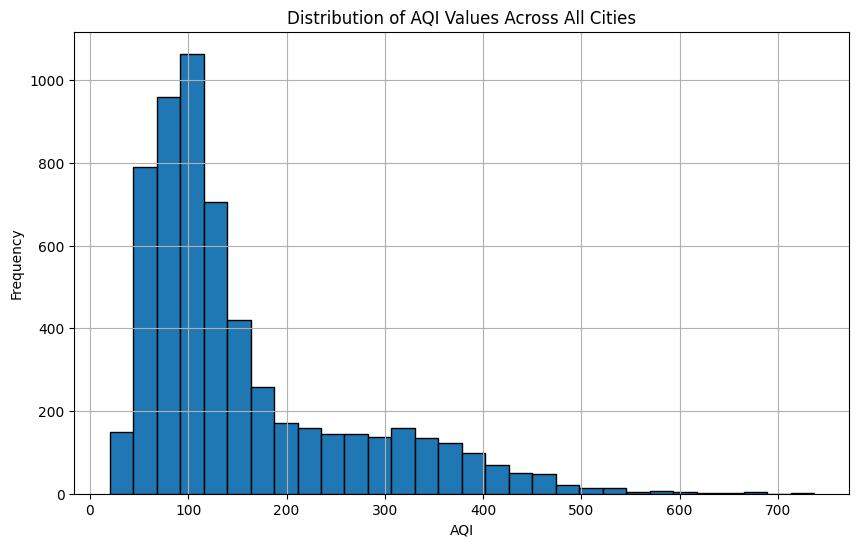

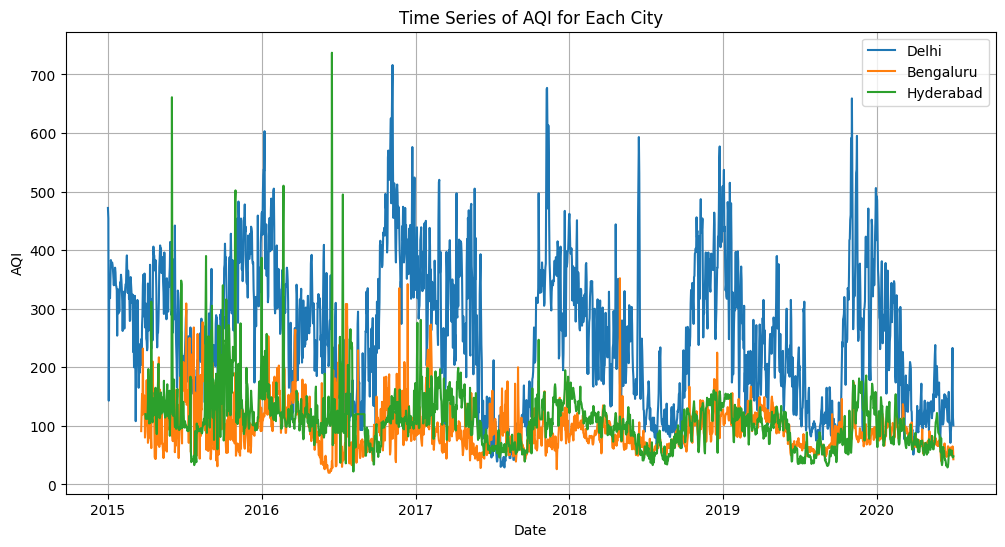

(              AQI
 count  5859.00000
 mean    155.54156
 std     109.38002
 min      20.00000
 25%      81.00000
 50%     114.00000
 75%     194.00000
 max     737.00000,
          City       Date    AQI
 1   Bengaluru 2015-01-01    NaN
 3       Delhi 2015-01-01  472.0
 7   Bengaluru 2015-01-02    NaN
 9       Delhi 2015-01-02  454.0
 13  Bengaluru 2015-01-03    NaN)

In [37]:

# Filter data for specific cities
cities_to_keep = ['Delhi', 'Bengaluru', 'Hyderabad']
df = df[df['City'].isin(cities_to_keep)]

# Retain only the desired columns: 'City', 'Date', and 'AQI'
df = df[['City', 'Date', 'AQI']]

# Convert 'Date' column to datetime data type
df['Date'] = pd.to_datetime(df['Date'])

# Replace NaN values in the 'AQI' column with next day's value (forward fill) for each city
df['AQI'] = df.groupby('City')['AQI'].fillna(method='ffill')

# Sort the DataFrame by the 'Date' column in ascending order
df.sort_values(by='Date', inplace=True)

# Basic statistics of the data
basic_stats = df.describe()

# Visualizing the first few rows of the data
head_data = df.head()

# Visualizing the distribution of AQI values
plt.figure(figsize=(10, 6))
plt.hist(df['AQI'].dropna(), bins=30, edgecolor='k')
plt.title('Distribution of AQI Values Across All Cities')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualizing time series of AQI for each city
plt.figure(figsize=(12, 6))
for city in cities_to_keep:
    plt.plot(df[df['City'] == city]['Date'], df[df['City'] == city]['AQI'], label=city)
plt.title('Time Series of AQI for Each City')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

(basic_stats, head_data)


In [38]:
# Time-based Train-Test Split
split_date = '2020-01-01'
train = df[df['Date'] < split_date]
test = df[df['Date'] >= split_date]

In [39]:
# Perform a time-based train-test split
split_date = '2020-01-01'  # Choose a date to split the data
train_df = df[df['Date'] < split_date]
test_df = df[df['Date'] >= split_date]

# Validate the split
train_stats = train_df.describe()
test_stats = test_df.describe()


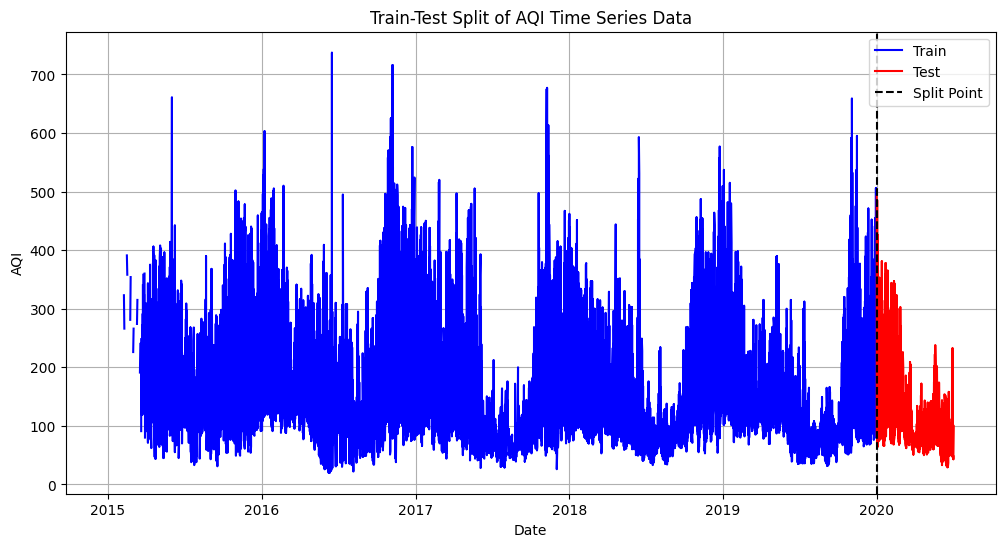

In [40]:
# Convert split_date to datetime object for plotting
split_date_dt = pd.to_datetime(split_date)

# Visualize the train and test splits with corrected split date
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['AQI'], label='Train', color='blue')
plt.plot(test_df['Date'], test_df['AQI'], label='Test', color='red')
plt.axvline(x=split_date_dt, color='k', linestyle='--', label='Split Point')
plt.title('Train-Test Split of AQI Time Series Data')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()


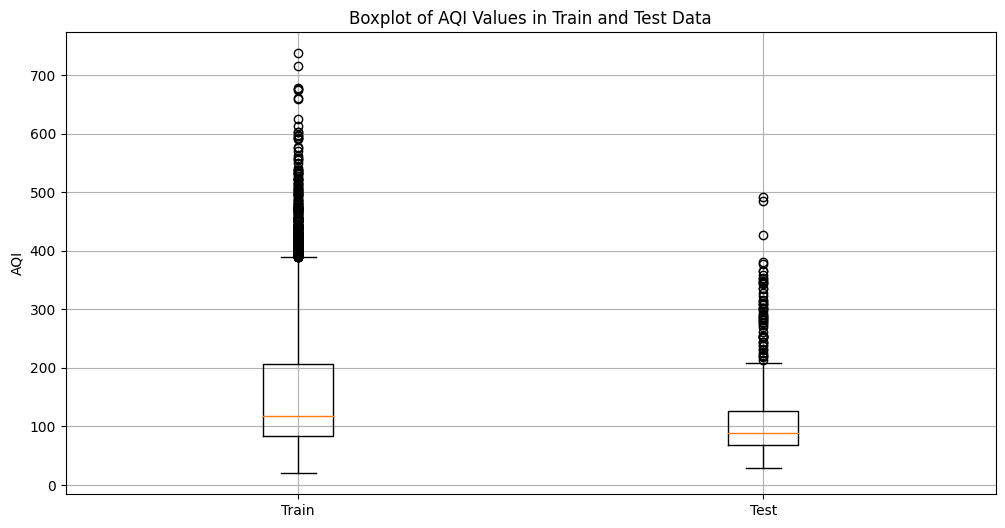

(159.92052730696798,
 113.18761384335154,
 12435.525421458568,
 5434.659992288567,
 0.22648266493779137,
 6.825839410634366e-23)

In [41]:
# Statistical Tests: Compare mean and variance of train and test datasets
mean_train = train_df['AQI'].mean()
mean_test = test_df['AQI'].mean()
var_train = train_df['AQI'].var()
var_test = test_df['AQI'].var()

# Kolmogorov-Smirnov test to compare the distributions of train and test datasets
ks_stat, ks_p_value = ks_2samp(train_df['AQI'].dropna(), test_df['AQI'].dropna())

# Boxplot to visualize seasonality and outliers
plt.figure(figsize=(12, 6))
plt.boxplot([train_df['AQI'].dropna(), test_df['AQI'].dropna()], labels=['Train', 'Test'])
plt.title('Boxplot of AQI Values in Train and Test Data')
plt.ylabel('AQI')
plt.grid(True)
plt.show()

(mean_train, mean_test, var_train, var_test, ks_stat, ks_p_value)

<ipython-input-42-9f2665e00432>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['AQI'].fillna(method='bfill', inplace=True)
<ipython-input-42-9f2665e00432>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['AQI'].fillna(method='ffill', inplace=True)


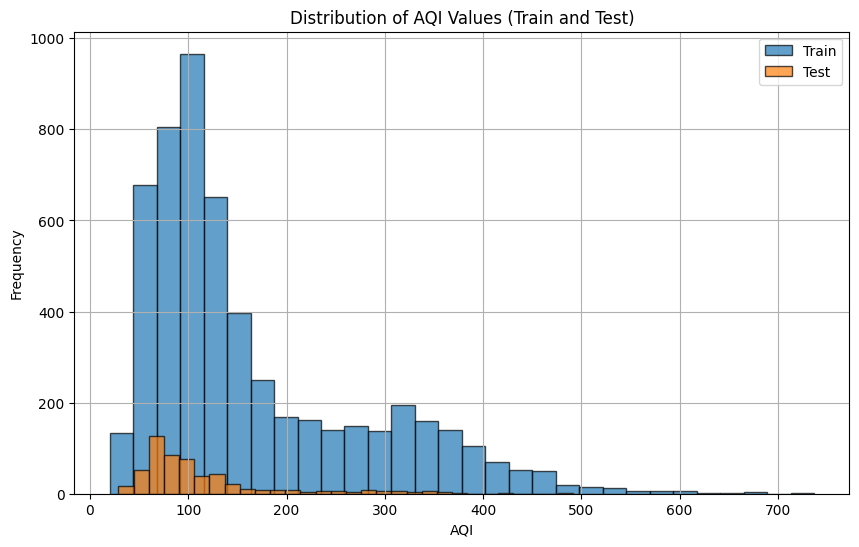

(165, 0, 0, 737.0, 492.0, dtype('float64'))

In [42]:
# Check for missing values in the training and test datasets
missing_train = train_df['AQI'].isnull().sum()
missing_test = test_df['AQI'].isnull().sum()

# Forward Fill missing values of the column
train_df['AQI'].fillna(method='bfill', inplace=True)
train_df['AQI'].fillna(method='ffill', inplace=True)

# Recheck for missing values after imputation
missing_train_after = train_df['AQI'].isnull().sum()

# Check for infinity or large values in the 'AQI' column
max_train = train_df['AQI'].max()
max_test = test_df['AQI'].max()

# Check the data type of the 'AQI' column
dtype_train = train_df['AQI'].dtype

# Visualizing the distribution of 'AQI' values after handling missing values
plt.figure(figsize=(10, 6))
plt.hist(train_df['AQI'], bins=30, edgecolor='k', alpha=0.7, label='Train')
plt.hist(test_df['AQI'], bins=30, edgecolor='k', alpha=0.7, label='Test')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.title('Distribution of AQI Values (Train and Test)')
plt.legend()
plt.grid(True)
plt.show()

(missing_train, missing_test, missing_train_after, max_train, max_test, dtype_train)


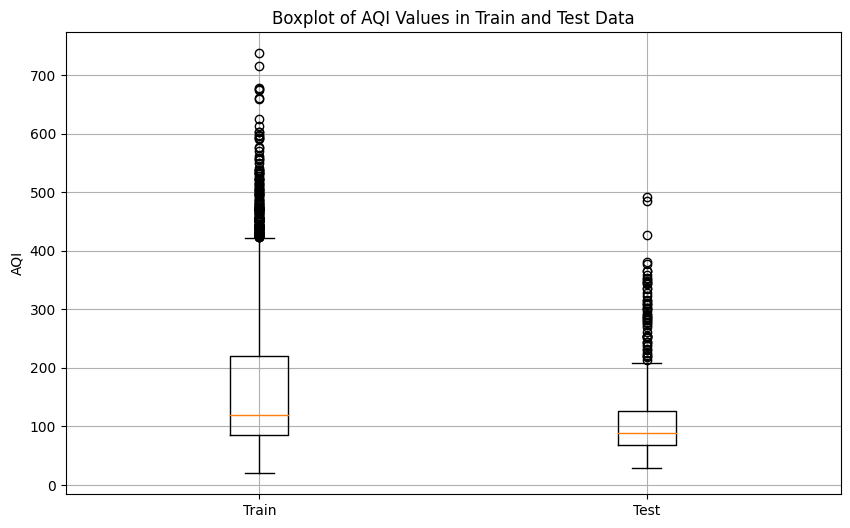

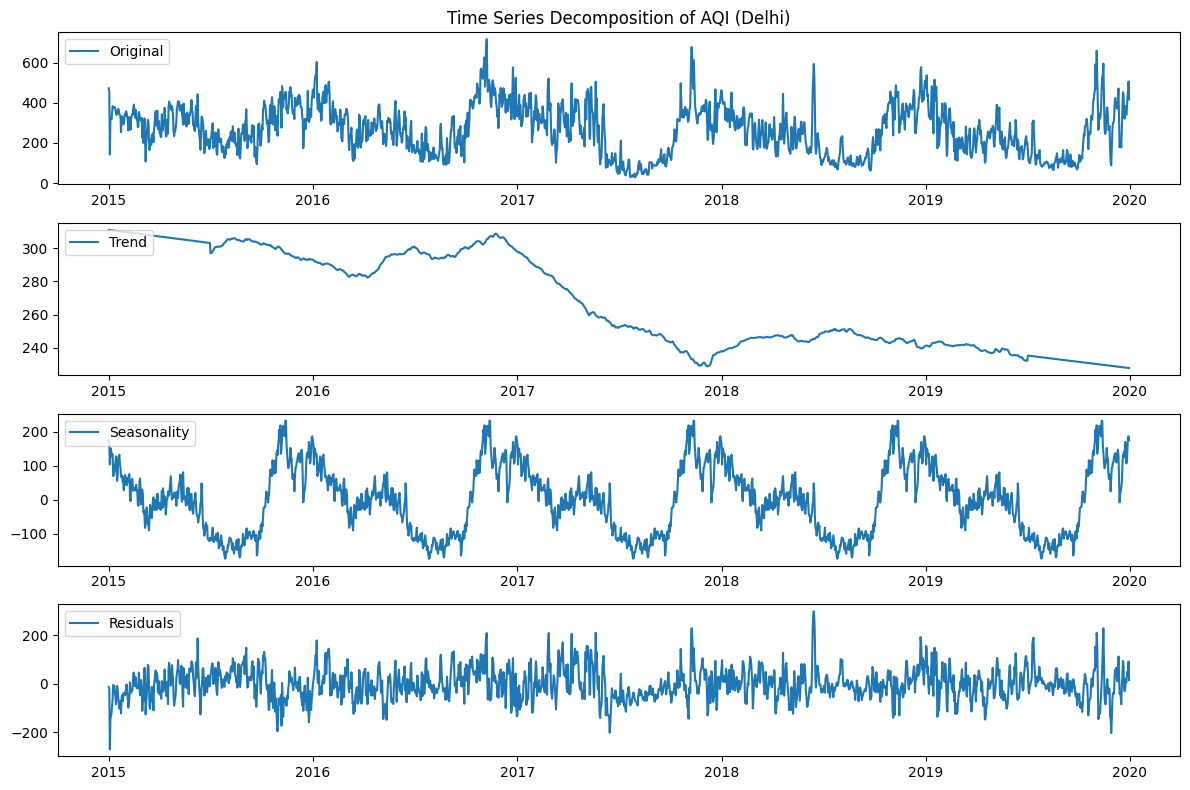

((True, True),
 -4.36857743664041,
 0.00033723712533019224,
 {'1%': -3.4315522027214076,
  '5%': -2.862071253100843,
  '10%': -2.567052785036848})

In [43]:
# Outlier Handling: Boxplot to visualize potential outliers in 'AQI' values
plt.figure(figsize=(10, 6))
plt.boxplot([train_df['AQI'], test_df['AQI']], labels=['Train', 'Test'])
plt.title('Boxplot of AQI Values in Train and Test Data')
plt.ylabel('AQI')
plt.grid(True)
plt.show()

# Stationarity Check: Augmented Dickey-Fuller test
adf_stat, p_value, _, _, critical_values, _ = adfuller(train_df['AQI'].dropna())
stationarity_check = (adf_stat < critical_values['5%'], p_value < 0.05)

# Seasonality and Trend Analysis: Decomposing the time series (for one city for clearer visualization)
decomposed = seasonal_decompose(train_df[train_df['City'] == 'Delhi']['AQI'].dropna(),
                                 period=365,  # assuming yearly seasonality
                                 extrapolate_trend='freq')
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

# Plotting decomposed time series
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(train_df[train_df['City'] == 'Delhi']['Date'], train_df[train_df['City'] == 'Delhi']['AQI'], label='Original')
plt.legend(loc='upper left')
plt.title('Time Series Decomposition of AQI (Delhi)')
plt.subplot(4, 1, 2)
plt.plot(train_df[train_df['City'] == 'Delhi']['Date'], trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(train_df[train_df['City'] == 'Delhi']['Date'], seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(train_df[train_df['City'] == 'Delhi']['Date'], residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

(stationarity_check, adf_stat, p_value, critical_values)


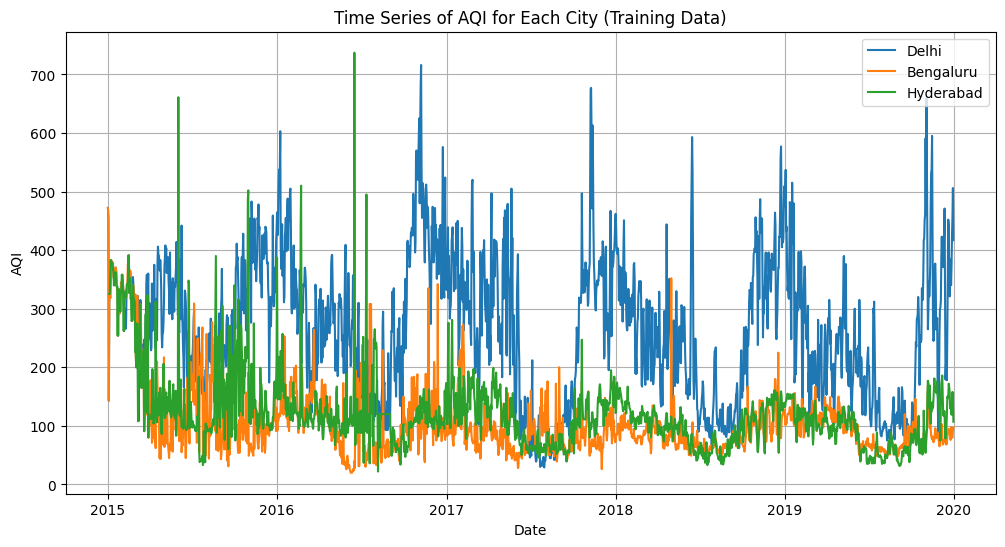

{'Delhi': {'ADF Statistic': -3.3202668100544073,
  'P-value': 0.013996498652373105,
  'Critical Values': {'1%': -3.433972018026501,
   '5%': -2.8631399192826676,
   '10%': -2.5676217442756872},
  'Is Stationary': True},
 'Bengaluru': {'ADF Statistic': -5.375074467535475,
  'P-value': 3.820362527281344e-06,
  'Critical Values': {'1%': -3.433962014811523,
   '5%': -2.86313550332995,
   '10%': -2.5676193929209554},
  'Is Stationary': True},
 'Hyderabad': {'ADF Statistic': -4.530449953686501,
  'P-value': 0.00017317359106946544,
  'Critical Values': {'1%': -3.4339921916016345,
   '5%': -2.8631488249300574,
   '10%': -2.5676264862577503},
  'Is Stationary': True}}

In [44]:
# Stationarity Check for each city in the training data
stationarity_results = {}

for city in cities_to_keep:
    city_data = train_df[train_df['City'] == city]['AQI'].dropna()
    adf_stat, p_value, _, _, critical_values, _ = adfuller(city_data)
    stationarity_results[city] = {
        'ADF Statistic': adf_stat,
        'P-value': p_value,
        'Critical Values': critical_values,
        'Is Stationary': adf_stat < critical_values['5%'] and p_value < 0.05
    }

# Visualizing time series of AQI for each city to check visually for stationarity
plt.figure(figsize=(12, 6))
for city in cities_to_keep:
    plt.plot(train_df[train_df['City'] == city]['Date'],
             train_df[train_df['City'] == city]['AQI'],
             label=city)
plt.title('Time Series of AQI for Each City (Training Data)')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

stationarity_results


In [45]:
# Ensure your data is loaded and preprocessed as per previous steps

# Select city-specific data for modeling (example: Delhi)
train_city_df = train_df[train_df['City'] == 'Delhi']['AQI'].dropna()
test_city_df = test_df[test_df['City'] == 'Delhi']['AQI'].dropna()

# Define and fit the SARIMA model
p, d, q = 1, 1, 1
P, D, Q, S = 5, 1, 1, 12
sarima_model = SARIMAX(train_city_df, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_results = sarima_model.fit(disp=False)  # disp=False suppresses output during fitting

# Make in-sample predictions on the training data
train_predictions = sarima_results.get_prediction(start=train_city_df.index[0], end=train_city_df.index[-1])
train_pred_mean = train_predictions.predicted_mean


# Make out-of-sample forecasts on the test data
forecast_steps = len(test_city_df)  # ensure we forecast for the entire test set
sarima_test_predictions = sarima_results.get_forecast(steps=forecast_steps)
sarima_y_pred = sarima_test_predictions.predicted_mean

# Print shapes for debugging
print("Shapes of datasets and predictions:")
print("Train data shape: ", train_city_df.shape)
print("Test data shape: ", test_city_df.shape)
print("Train predictions shape: ", train_pred_mean.shape)
print("Test predictions shape: ", sarima_y_pred.shape)

# Ensure the forecast index matches the test data index
sarima_y_pred.index = test_city_df.index


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No s

Shapes of datasets and predictions:
Train data shape:  (1826,)
Test data shape:  (183,)
Train predictions shape:  (24869,)
Test predictions shape:  (183,)


In [46]:
# Evaluate the model’s performance
sarima_mape = mean_absolute_percentage_error(test_city_df, sarima_y_pred)
sarima_rmse = mean_squared_error(test_city_df, sarima_y_pred, squared=False)


# Display the evaluation metrics
print(f"SARIMA Mean Absolute Percentage Error (MAPE): {sarima_mape:.2f}")
print(f"SARIMA Root Mean Squared Error (RMSE): {sarima_rmse:.2f}")


SARIMA Mean Absolute Percentage Error (MAPE): 0.64
SARIMA Root Mean Squared Error (RMSE): 89.56


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


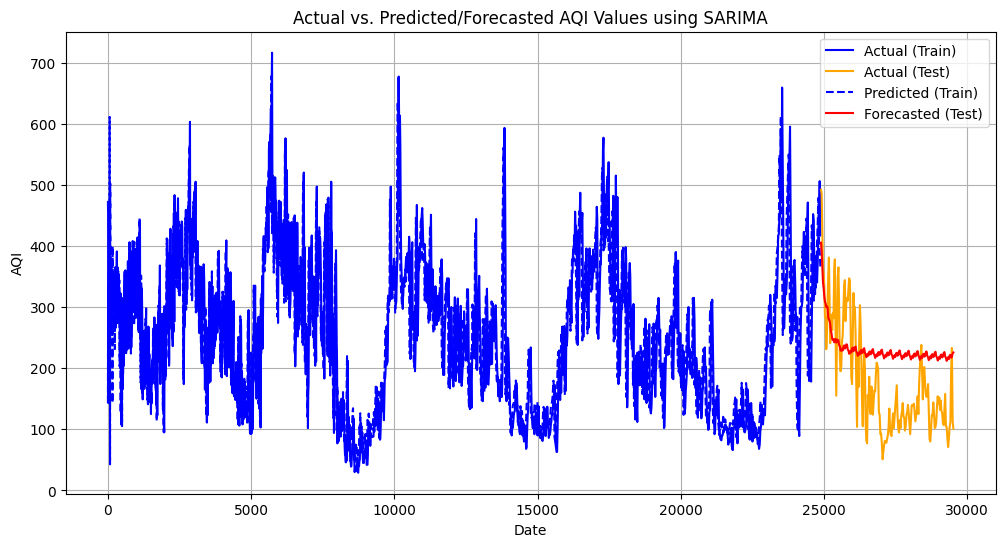

In [47]:
# Ensure the forecast steps equal the size of the test dataset
forecast_steps = len(test_city_df)

# Re-run the SARIMA forecasting with the revised steps
sarima_test_predictions = sarima_results.get_forecast(steps=forecast_steps)
sarima_y_pred = sarima_test_predictions.predicted_mean

# Ensure the prediction index matches the test data index for plotting
sarima_y_pred.index = test_city_df.index

# Visualize the actual vs. predicted values with revised data
plt.figure(figsize=(12, 6))

# Plotting Actual (Train)
plt.plot(train_city_df.index, train_city_df, label='Actual (Train)', color='blue')

# Plotting Actual (Test)
plt.plot(test_city_df.index, test_city_df, label='Actual (Test)', color='orange')

# Plotting Predicted (Train) - Ensuring indices match
plt.plot(train_city_df.index, train_pred_mean.iloc[:len(train_city_df)], label='Predicted (Train)', color='blue', linestyle='dashed')

# Plotting Forecasted (Test)
plt.plot(test_city_df.index, sarima_y_pred, label='Forecasted (Test)', color='red')

plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Actual vs. Predicted/Forecasted AQI Values using SARIMA')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
# Ensuring 'AQI' is available in the DataFrame for the chosen city (Delhi)
train_city_df = train_df[train_df['City'] == 'Delhi'][['Date', 'AQI']].set_index('Date')

# Defining a function to create lagged features
def create_lagged_features(series, lags):
    df = pd.DataFrame(series)
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['AQI'].shift(i)
    return df.iloc[lags:]  # removing NaN rows created due to lagging

# Creating lagged features (using 5 lags as an example)
lags = 5
train_city_lagged = create_lagged_features(train_city_df, lags)

# Verifying the structure of the lagged DataFrame
print(train_city_lagged.head())

              AQI  lag_1  lag_2  lag_3  lag_4  lag_5
Date                                                
2015-01-06  318.0  325.0  319.0  143.0  454.0  472.0
2015-01-07  353.0  318.0  325.0  319.0  143.0  454.0
2015-01-08  383.0  353.0  318.0  325.0  319.0  143.0
2015-01-09  375.0  383.0  353.0  318.0  325.0  319.0
2015-01-10  376.0  375.0  383.0  353.0  318.0  325.0


In [49]:
# Feature Engineering: Creating lagged variables as features
def create_lagged_features(df, lags):
    df_lagged = df.copy()
    for i in range(1, lags + 1):
        df_lagged[f"lag_{i}"] = df_lagged['AQI'].shift(i)
    return df_lagged.dropna()

# Creating lagged features (using 5 lags as an example)
lags = 5
train_city_lagged = create_lagged_features(train_city_df.reset_index(drop=True), lags)

In [50]:
# Splitting into features (X) and target (y) variables
X_train = train_city_lagged.iloc[:, 1:]
y_train = train_city_lagged['AQI']

# Create and train an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [51]:
# Ensuring 'AQI' is available in the DataFrame for the chosen city (Delhi)
test_city_df = test_df[test_df['City'] == 'Delhi'][['Date', 'AQI']].set_index('Date')

# Utilizing the previously defined function to create lagged features
lags = 5
test_city_lagged = create_lagged_features(test_city_df, lags).iloc[:, 1:]

# Making predictions using the XGBoost model
xgb_y_pred = xgb_model.predict(test_city_lagged)


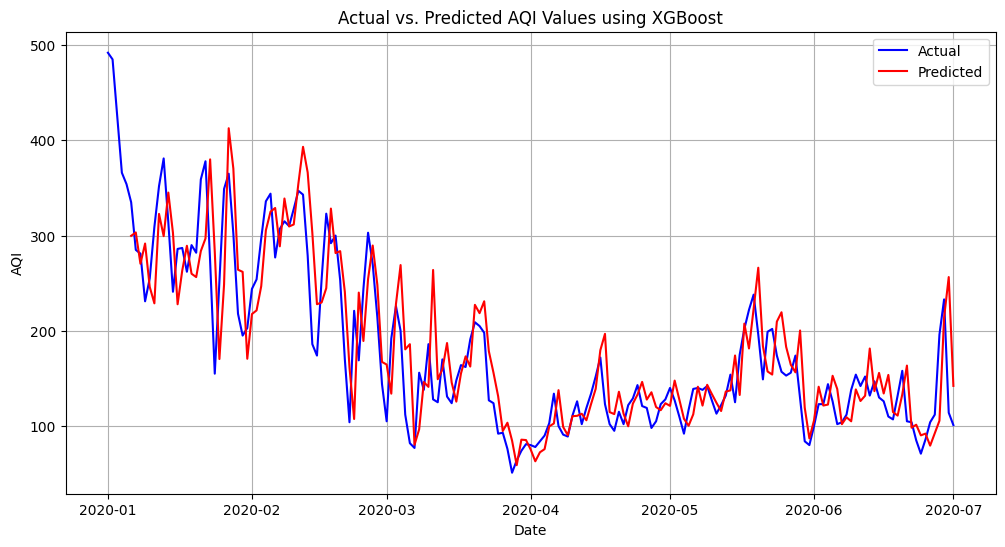

(0.2043654070604899, 43.673065990908555)

In [52]:
# Creating lagged features for test data and making predictions
test_city_lagged = create_lagged_features(test_city_df.reset_index(drop=True), lags).iloc[:, 1:]
xgb_y_pred = xgb_model.predict(test_city_lagged)


# Evaluate the XGBoost model's performance
xgb_mape = mean_absolute_percentage_error(test_city_df[lags:], xgb_y_pred)
xgb_rmse = mean_squared_error(test_city_df[lags:], xgb_y_pred, squared=False)

# Visualize the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_city_df.index, test_city_df, label='Actual', color='blue')
plt.plot(test_city_df.index[lags:], xgb_y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Actual vs. Predicted AQI Values using XGBoost')
plt.legend()
plt.grid(True)
plt.show()

(xgb_mape, xgb_rmse)


In [53]:
# Defining a custom scoring function for GridSearchCV
def custom_scorer(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)  # RMSE

# Defining the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# Creating the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Setting up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=make_scorer(custom_scorer, greater_is_better=False),  # to minimize RMSE
    cv=3,  # 3-fold cross-validation
    verbose=2,  # print detailed logs
    n_jobs=-1  # use all available CPUs
)

# Running the grid search
grid_search.fit(X_train, y_train)

# Retrieving the best parameters and the corresponding RMSE
best_params = grid_search.best_params_
best_rmse = abs(grid_search.best_score_)

(best_params, best_rmse)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


({'colsample_bytree': 1.0,
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 50,
  'subsample': 1.0},
 53.61268846564985)

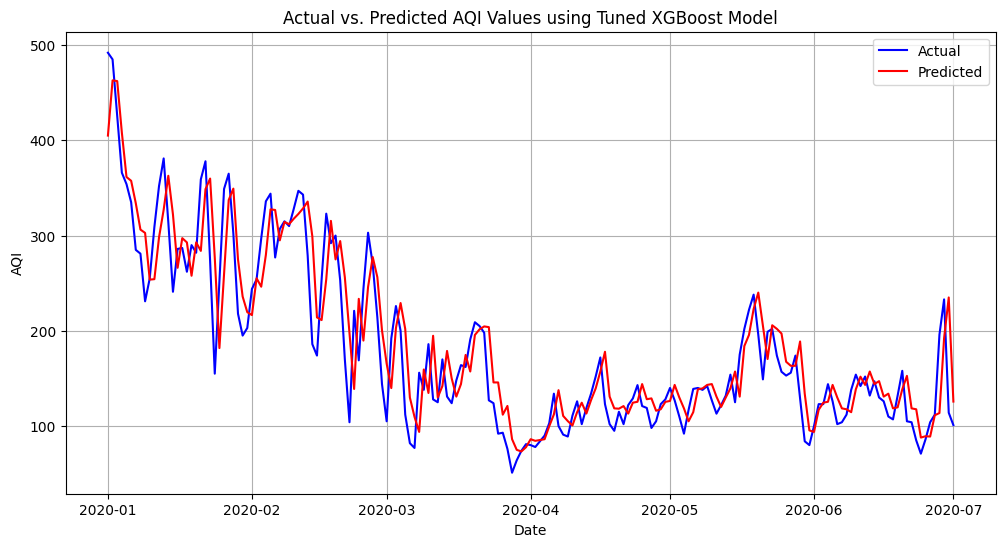

(0.18595420336972543, 39.20948002012108)

In [54]:
# Load the dataset from the provided URL
url = 'https://raw.githubusercontent.com/datagrad/MS_Reference_MS-DS-LJMU-C13/main/city_day.csv'
df = pd.read_csv(url)
df = df[df['City'] == 'Delhi'][['Date', 'AQI']].dropna()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Create lagged features
def create_lagged_features(df, lags):
    df_lagged = df.copy()
    for i in range(1, lags + 1):
        df_lagged[f"lag_{i}"] = df_lagged['AQI'].shift(i)
    return df_lagged.iloc[lags:]

lags = 5
df_lagged = create_lagged_features(df, lags)

# Train-test split
split_date = '2020-01-01'
train_df = df_lagged[df_lagged.index < split_date]
test_df = df_lagged[df_lagged.index >= split_date]

# Define X and y
X_train = train_df.drop(columns=['AQI'])
y_train = train_df['AQI']
X_test = test_df.drop(columns=['AQI'])
y_test = test_df['AQI']

# Model building with tuned hyperparameters
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 50,
    'subsample': 1.0
}
xgb_model_tuned = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
xgb_model_tuned.fit(X_train, y_train)

# Predictions
xgb_y_pred_tuned = xgb_model_tuned.predict(X_test)

# Evaluation
xgb_mape_tuned = mean_absolute_percentage_error(y_test, xgb_y_pred_tuned)
xgb_rmse_tuned = mean_squared_error(y_test, xgb_y_pred_tuned, squared=False)

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, xgb_y_pred_tuned, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Actual vs. Predicted AQI Values using Tuned XGBoost Model')
plt.legend()
plt.grid(True)
plt.show()

(xgb_mape_tuned, xgb_rmse_tuned)


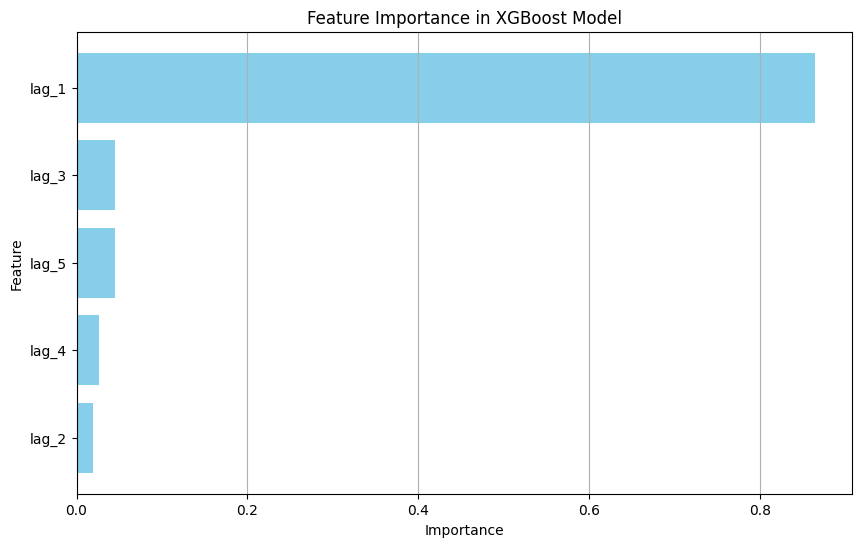

Feature  Importance
0   lag_1    0.863538
2   lag_3    0.045259
4   lag_5    0.045183
3   lag_4    0.026609
1   lag_2    0.019411

In [55]:
# Extracting feature importance
feature_importance = xgb_model_tuned.feature_importances_

# Creating a DataFrame for visualization
feature_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sorting based on importance
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Visualizing feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.grid(axis='x')
plt.show()

# Returning feature importance in a DataFrame for reference
feature_df


In [56]:
xgb_y_pred_tuned = xgb_model_tuned.predict(X_test)

In [57]:
residuals = y_test - xgb_y_pred_tuned

In [58]:
print(y_test.isnull().sum())
print(pd.isnull(xgb_y_pred_tuned).sum())

0
0


In [59]:
print(residuals.head())

Date
2020-01-01    87.002106
2020-01-02    22.017639
2020-01-03   -36.216766
2020-01-04   -42.050293
2020-01-05    -7.485413
Name: AQI, dtype: float64


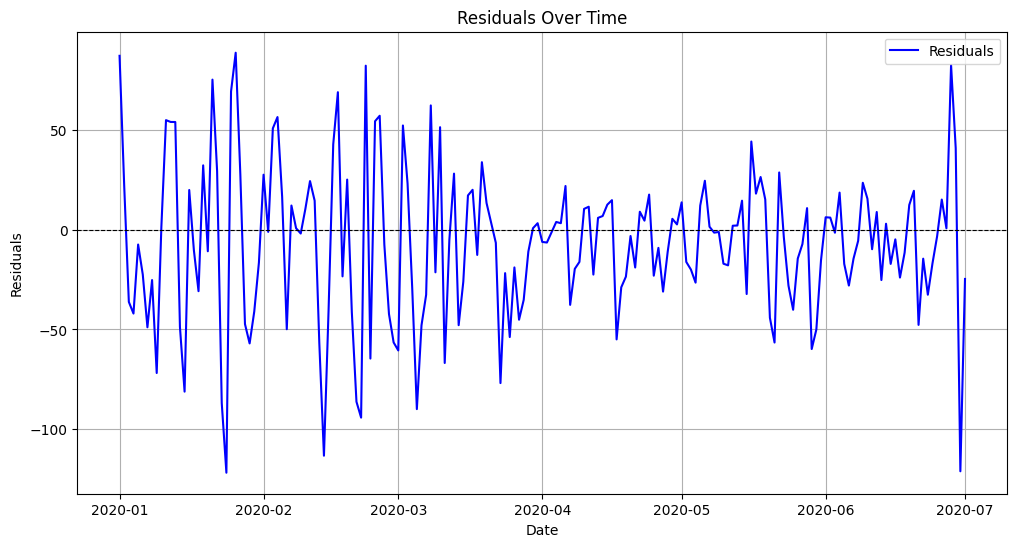

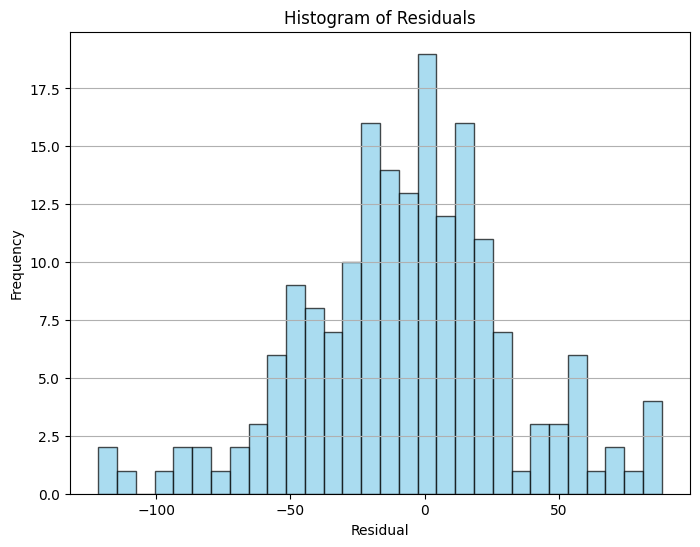

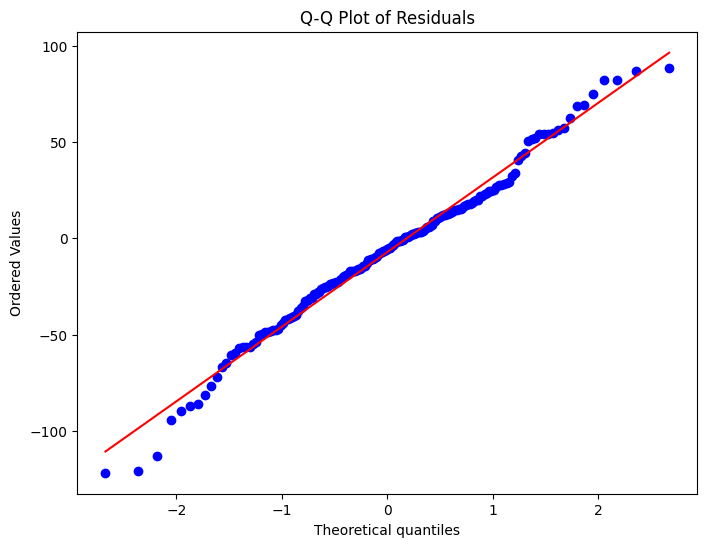

Durbin-Watson Statistic: 1.5721292157282702


In [60]:
# Assuming residuals are stored in a variable named 'residuals'
# Visualization of residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, label='Residuals', color='blue')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7, color='skyblue')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(axis='y')
plt.show()

# Q-Q plot of residuals
plt.figure(figsize=(8, 6))
probplot(residuals, plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Durbin-Watson statistic
durbin_watson_stat = sm.stats.durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {durbin_watson_stat}")


In [61]:
# Define the window size and step size for rolling window
window_size = 365  # for example, train on a year of data at a time
step_size = 7  # move the window forward by one week at a time

# Define the first window to start
start = 0
end = window_size

# Rolling-window validation
while end < len(df_lagged):
    train = df_lagged.iloc[start:end]
    test = df_lagged.iloc[end:end+step_size]

    X_train, y_train = train.drop(columns=['AQI']), train['AQI']
    X_test, y_test = test.drop(columns=['AQI']), test['AQI']

    xgb_model_tuned.fit(X_train, y_train)
    predictions = xgb_model_tuned.predict(X_test)

    # Evaluation metric (e.g., RMSE) for this window
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f'RMSE for window {start}-{end}: {rmse}')

    # Move the window
    start += step_size
    end += step_size


RMSE for window 0-365: 82.66059680677878
RMSE for window 7-372: 65.84307419398546
RMSE for window 14-379: 47.65862391069965
RMSE for window 21-386: 70.78980960789177
RMSE for window 28-393: 51.35377461814198
RMSE for window 35-400: 33.073689384824334
RMSE for window 42-407: 50.98140626671737
RMSE for window 49-414: 42.66013798816625
RMSE for window 56-421: 48.582577749161594
RMSE for window 63-428: 57.482543125303586
RMSE for window 70-435: 48.20143850836205
RMSE for window 77-442: 71.49076334600838
RMSE for window 84-449: 48.00736020916617
RMSE for window 91-456: 51.49917256567007
RMSE for window 98-463: 35.757897770508905
RMSE for window 105-470: 37.566648790341986
RMSE for window 112-477: 51.62322960649657
RMSE for window 119-484: 34.449632507353535
RMSE for window 126-491: 37.15945128569843
RMSE for window 133-498: 36.5420155023789
RMSE for window 140-505: 85.51662476767082
RMSE for window 147-512: 40.42982553304359
RMSE for window 154-519: 56.18922004346899
RMSE for window 161-526

In [62]:
# Evaluate model on a specific year or month
specific_period_data = df_lagged['2020']  # replace with desired period
X = specific_period_data.drop(columns=['AQI'])
y = specific_period_data['AQI']

predictions = xgb_model_tuned.predict(X)
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f'RMSE for specific period: {rmse}')


RMSE for specific period: 27.375270348055846


<ipython-input-62-dd49ea4e74b6>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  specific_period_data = df_lagged['2020']  # replace with desired period


In [63]:
# Example: Evaluate model with missing values imputed
df_missing = df_lagged.copy()
df_missing['lag_1'] = df_missing['lag_1'].replace(np.nan, df_missing['lag_1'].mean())  # or use other imputation method

X = df_missing.drop(columns=['AQI'])
y = df_missing['AQI']

predictions = xgb_model_tuned.predict(X)
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f'RMSE with missing values imputed: {rmse}')


RMSE with missing values imputed: 53.72174038081583
